In [1]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album
import segmentation_models_pytorch as smp

ImportError: cannot import name 'TypeAliasType' from 'typing_extensions' (/home/vpancho1/.conda/envs/rsenv/lib/python3.8/site-packages/typing_extensions.py)

In [2]:
from segmentation_models_pytorch import utils as util

In [3]:
# !pip install --use-feature=2020-resolver -q -U segmentation-models-pytorch==0.1.2 albumentations > /dev/null

In [4]:
#Data Loading and spliting
DATA_DIR = 'landCoverDataset'

metadata_df = pd.read_csv(os.path.join(DATA_DIR, 'metadata.csv'))
metadata_df = metadata_df[metadata_df['split']=='train']
metadata_df = metadata_df[['image_id', 'sat_image_path', 'mask_path']]
metadata_df['sat_image_path'] = metadata_df['sat_image_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
metadata_df['mask_path'] = metadata_df['mask_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
# Shuffle DataFrame
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)

# Perform 90/10 split for train / val
valid_df = metadata_df.sample(frac=0.1, random_state=42)
train_df = metadata_df.drop(valid_df.index)
len(train_df), len(valid_df)

(723, 80)

In [5]:
train_df.head()

,image_id,sat_image_path,mask_path
0,170535,landCoverDataset/train/170535_sat.jpg,landCoverDataset/train/170535_mask.png
1,362191,landCoverDataset/train/362191_sat.jpg,landCoverDataset/train/362191_mask.png
2,40168,landCoverDataset/train/40168_sat.jpg,landCoverDataset/train/40168_mask.png
3,943943,landCoverDataset/train/943943_sat.jpg,landCoverDataset/train/943943_mask.png
4,100694,landCoverDataset/train/100694_sat.jpg,landCoverDataset/train/100694_mask.png


In [6]:
# Spliting the data
original_image = cv2.imread(train_df['sat_image_path'][2])

Premature end of JPEG file


In [7]:
# #Split the image
# tile_size = 512
# tiles = []
# for i in range(0, original_image.shape[0], tile_size):
#     for j in range(0, original_image.shape[1], tile_size):
#         tile = original_image[i:i+tile_size, j:j+tile_size]
#         tiles.append(tile)

In [8]:
# # Copy the excess part and add padding
# last_tile_row = original_image.shape[0] // tile_size
# last_tile_col = original_image.shape[1] // tile_size
# last_tile = original_image[last_tile_row * tile_size:, last_tile_col * tile_size:]

# # Calculate the padding needed for each side
# pad_top = (tile_size - last_tile.shape[0]) // 2
# pad_bottom = tile_size - last_tile.shape[0] - pad_top
# pad_left = (tile_size - last_tile.shape[1]) // 2
# pad_right = tile_size - last_tile.shape[1] - pad_left

# # Add padding to the last tile
# last_tile = cv2.copyMakeBorder(last_tile, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=(0, 0, 0))

# tiles.append(last_tile)

In [9]:
# folder_path = "output_image/"  # Path to the output folder where you want to save the tiles
# main_image_id = train_df['image_id'][2] # ID of the main image

# # Save each tile with the specified file names
# for idx, tile in enumerate(tiles):
#     file_name = f"{main_image_id}_{idx+1}.jpg"  # Construct the file name
#     file_path = folder_path + file_name  # Construct the file path
#     cv2.imwrite(file_path, tile)

In [10]:
ls

119_sat.jpg         Detcon/            requirements.txt     superpixel.ipynb
best_model.pth      landCoverDataset/  resnet50.ipynb
DeepLabV3imp.ipynb  output_image/      sample_predictions/


In [11]:
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'class_dict.csv'))
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']
Class RGB values:  [[0, 255, 255], [255, 255, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]


In [12]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']
Class RGB values:  [[0, 255, 255], [255, 255, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]


In [13]:
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [14]:
class LandCoverDataset(torch.utils.data.Dataset):

    """DeepGlobe Land Cover Classification Challenge Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        df (str): DataFrame containing images / labels paths
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    def __init__(
            self, 
            df,
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.image_paths = df['sat_image_path'].tolist()
        self.mask_paths = df['mask_path'].tolist()
        
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

Premature end of JPEG file


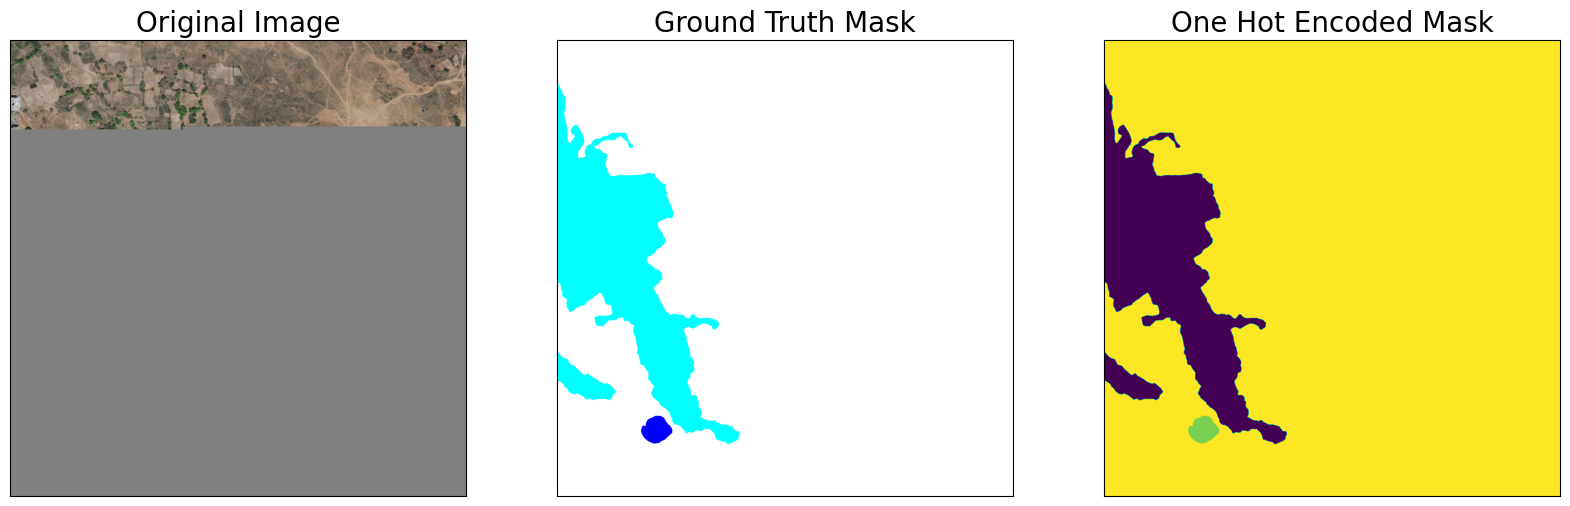

In [15]:
dataset = LandCoverDataset(train_df, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [16]:
def get_training_augmentation():
    train_transform = [
        album.RandomCrop(height=1024, width=1024, always_apply=True),
        album.HorizontalFlip(p=0.5),
        album.VerticalFlip(p=0.5),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():
    train_transform = [
        album.CenterCrop(height=1024, width=1024, always_apply=True),
    ]
    return album.Compose(train_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

Premature end of JPEG file


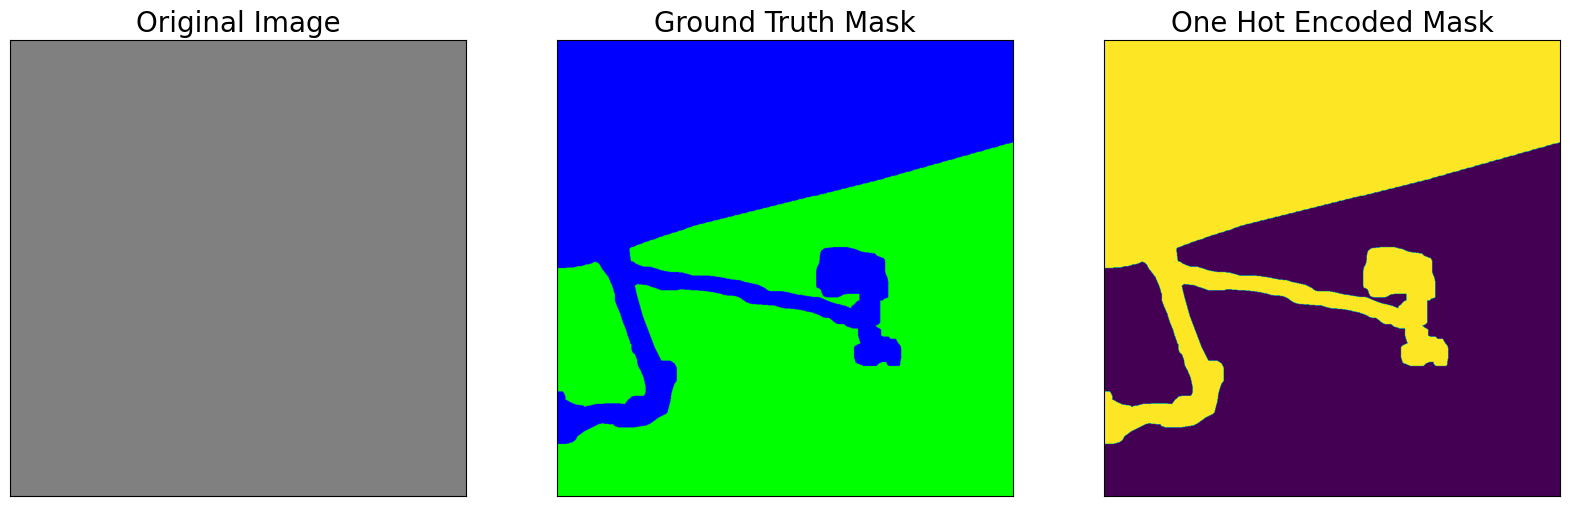

Premature end of JPEG file


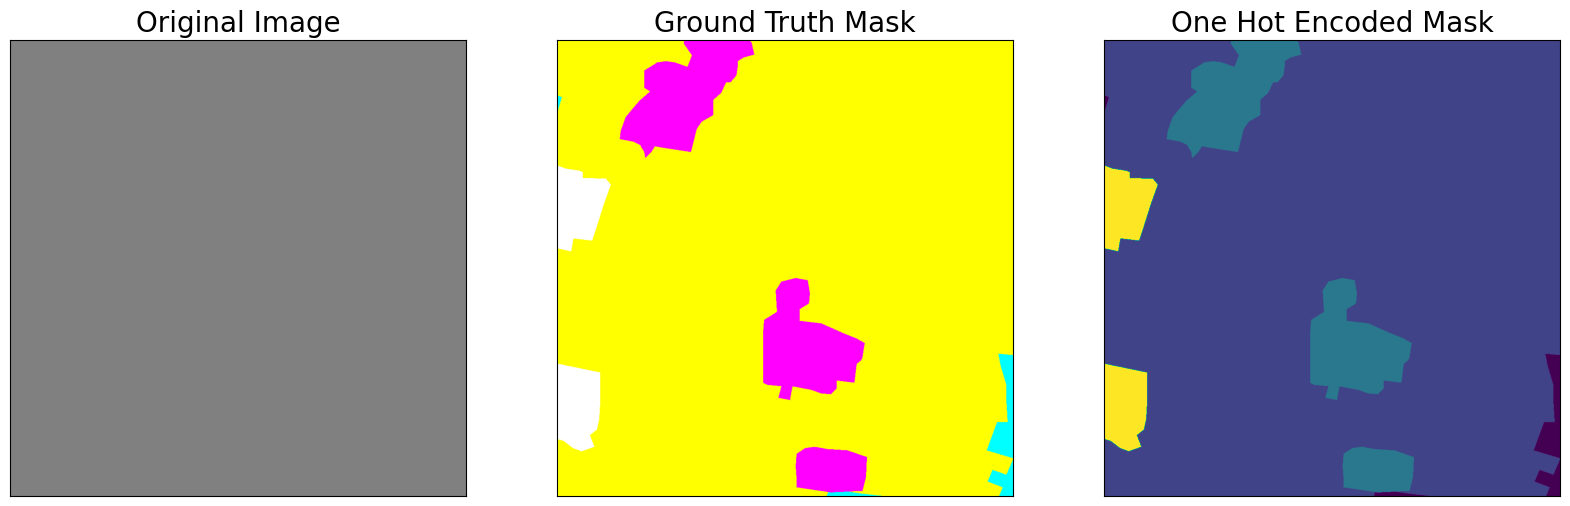

Premature end of JPEG file


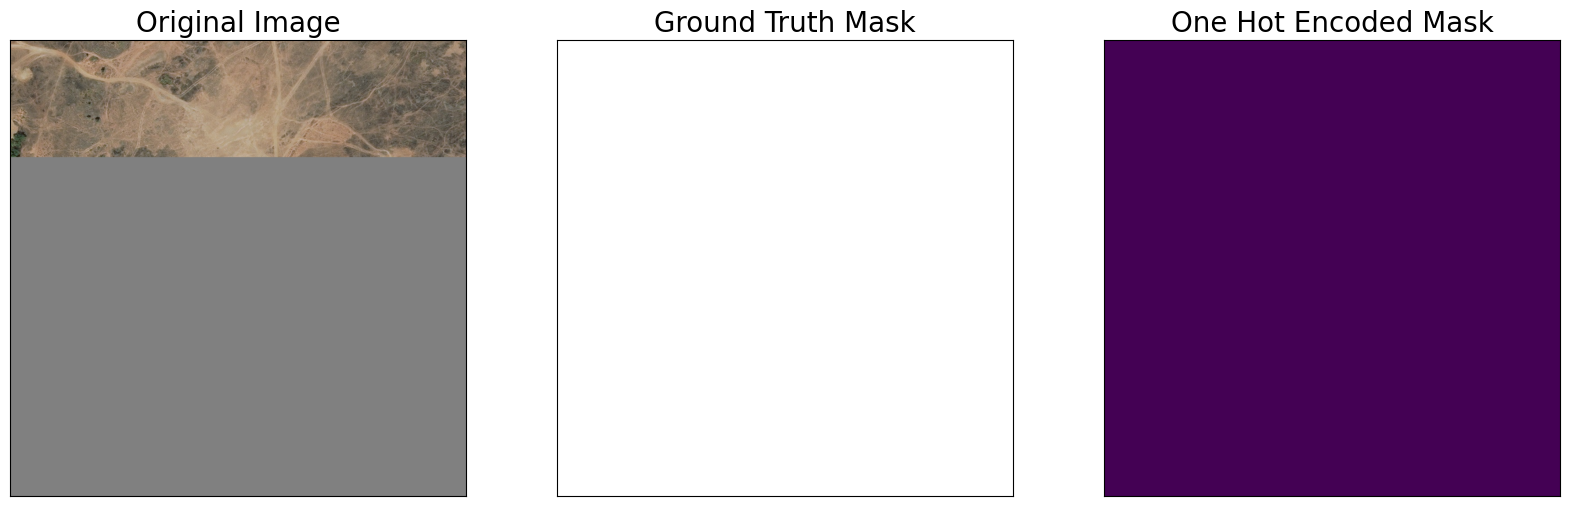

In [17]:
augmented_dataset = LandCoverDataset(
    train_df, 
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on image/mask pairs
for idx in range(3):
    image, mask = augmented_dataset[idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

In [18]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [19]:
train_dataset = LandCoverDataset(
    train_df, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = LandCoverDataset(
    valid_df, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

In [20]:
TRAINING = True

EPOCHS = 5

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss = util.losses.DiceLoss()

metrics = [
    util.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00008),
])


lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

if os.path.exists('../input/deepglobe-land-cover-classification-deeplabv3/best_model.pth'):
    model = torch.load('../input/deepglobe-land-cover-classification-deeplabv3/best_model.pth', map_location=DEVICE)
    print('Loaded pre-trained DeepLabV3+ model!')

In [21]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [22]:
model

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [ ]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')

In [18]:
# load best saved model checkpoint from the current run
if os.path.exists('./best_model.pth'):
    best_model = torch.load('./best_model.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from this run.')

# load best saved model checkpoint from previous commit (if present)
elif os.path.exists('../input/deepglobe-land-cover-classification-deeplabv3/best_model.pth'):
    best_model = torch.load('../input/deepglobe-land-cover-classification-deeplabv3/best_model.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from a previous commit.')

Loaded DeepLabV3+ model from this run.


Premature end of JPEG file


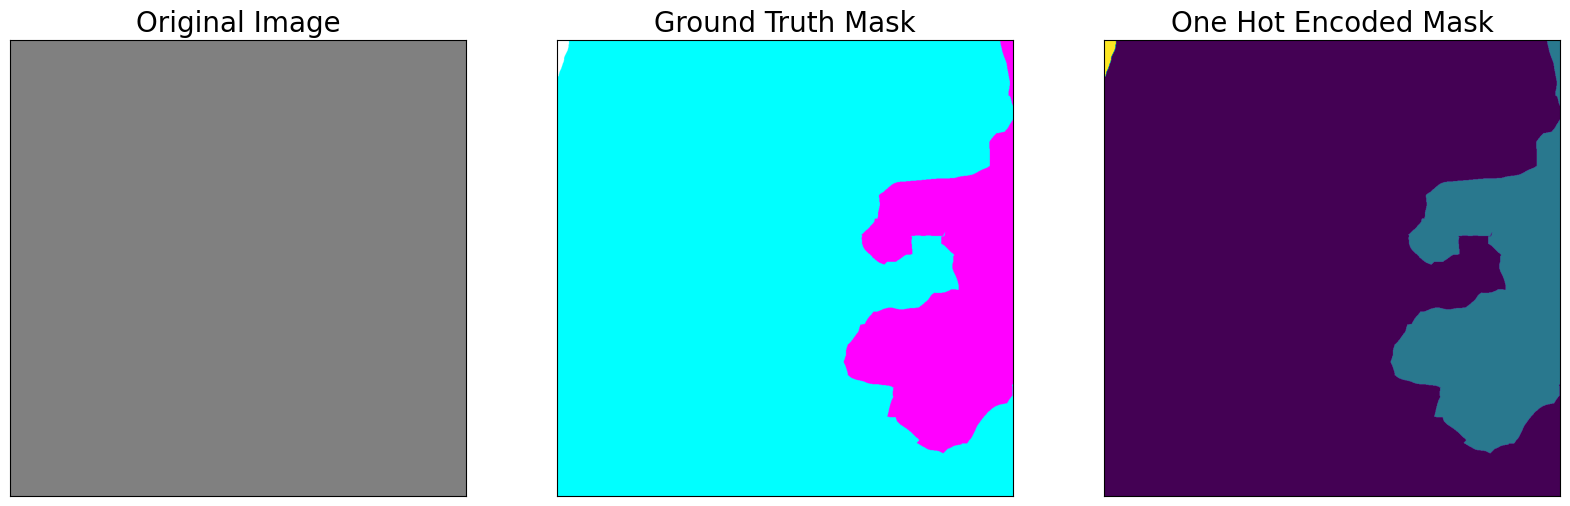

In [19]:
# create test dataloader to be used with DeepLabV3+ model (with preprocessing operation: to_tensor(...))
test_dataset = LandCoverDataset(
    valid_df, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing augmentations & transformations)
test_dataset_vis = LandCoverDataset(
    valid_df,
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [20]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [21]:
best_model = model

In [22]:
for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]
    image_vis = test_dataset_vis[idx][0].astype('uint8')
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to foreground
    pred_urban_land_heatmap = pred_mask[:,:,select_classes.index('urban_land')]
    pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values)
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])

    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        pred_urban_land_heatmap = pred_urban_land_heatmap
    )

Premature end of JPEG file
Premature end of JPEG file


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])

In [33]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid:   0%|          | 0/80 [00:00<?, ?it/s]

Premature end of JPEG file


valid:   1%|▏         | 1/80 [00:01<02:20,  1.77s/it, dice_loss - 0.7743, iou_score - 0.1999]

Premature end of JPEG file


valid:   2%|▎         | 2/80 [00:04<02:49,  2.17s/it, dice_loss - 0.774, iou_score - 0.2]    

Premature end of JPEG file


valid:   4%|▍         | 3/80 [00:06<02:57,  2.30s/it, dice_loss - 0.7745, iou_score - 0.1993]

Premature end of JPEG file


valid:   5%|▌         | 4/80 [00:09<03:00,  2.38s/it, dice_loss - 0.7748, iou_score - 0.197] 

Premature end of JPEG file


valid:   6%|▋         | 5/80 [00:11<02:59,  2.39s/it, dice_loss - 0.7764, iou_score - 0.1624]

Premature end of JPEG file


valid:   8%|▊         | 6/80 [00:14<02:59,  2.42s/it, dice_loss - 0.776, iou_score - 0.1673] 

Premature end of JPEG file


valid:   9%|▉         | 7/80 [00:16<02:57,  2.44s/it, dice_loss - 0.7757, iou_score - 0.1705]

Premature end of JPEG file


valid:  10%|█         | 8/80 [00:19<02:55,  2.44s/it, dice_loss - 0.7755, iou_score - 0.174] 

Premature end of JPEG file


valid:  11%|█▏        | 9/80 [00:21<02:54,  2.46s/it, dice_loss - 0.7753, iou_score - 0.1767]

Premature end of JPEG file


valid:  12%|█▎        | 10/80 [00:23<02:52,  2.47s/it, dice_loss - 0.7752, iou_score - 0.1796]

Premature end of JPEG file


valid:  14%|█▍        | 11/80 [00:26<02:50,  2.48s/it, dice_loss - 0.7751, iou_score - 0.1815]

Premature end of JPEG file


valid:  15%|█▌        | 12/80 [00:28<02:48,  2.48s/it, dice_loss - 0.775, iou_score - 0.1818] 

Premature end of JPEG file


valid:  16%|█▋        | 13/80 [00:31<02:46,  2.48s/it, dice_loss - 0.7751, iou_score - 0.1832]

Premature end of JPEG file


valid:  18%|█▊        | 14/80 [00:33<02:43,  2.47s/it, dice_loss - 0.775, iou_score - 0.1838] 

Premature end of JPEG file


valid:  19%|█▉        | 15/80 [00:36<02:41,  2.48s/it, dice_loss - 0.7749, iou_score - 0.1845]

Premature end of JPEG file


valid:  20%|██        | 16/80 [00:38<02:37,  2.46s/it, dice_loss - 0.7749, iou_score - 0.1855]

Premature end of JPEG file


valid:  21%|██▏       | 17/80 [00:41<02:35,  2.46s/it, dice_loss - 0.7751, iou_score - 0.1781]

Premature end of JPEG file


valid:  22%|██▎       | 18/80 [00:43<02:33,  2.47s/it, dice_loss - 0.7751, iou_score - 0.1793]

Premature end of JPEG file


valid:  24%|██▍       | 19/80 [00:46<02:30,  2.47s/it, dice_loss - 0.7754, iou_score - 0.1723]

Premature end of JPEG file


valid:  25%|██▌       | 20/80 [00:48<02:27,  2.46s/it, dice_loss - 0.7757, iou_score - 0.1672]

Premature end of JPEG file


valid:  26%|██▋       | 21/80 [00:51<02:25,  2.47s/it, dice_loss - 0.7756, iou_score - 0.1688]

Premature end of JPEG file


valid:  28%|██▊       | 22/80 [00:53<02:23,  2.47s/it, dice_loss - 0.7755, iou_score - 0.1702]

Premature end of JPEG file


valid:  29%|██▉       | 23/80 [00:56<02:20,  2.46s/it, dice_loss - 0.7754, iou_score - 0.1711]

Premature end of JPEG file


valid:  30%|███       | 24/80 [00:58<02:18,  2.47s/it, dice_loss - 0.7754, iou_score - 0.1719]

Premature end of JPEG file


valid:  31%|███▏      | 25/80 [01:01<02:15,  2.46s/it, dice_loss - 0.7754, iou_score - 0.1724]

Premature end of JPEG file


valid:  32%|███▎      | 26/80 [01:03<02:13,  2.46s/it, dice_loss - 0.7753, iou_score - 0.1735]

Premature end of JPEG file


valid:  34%|███▍      | 27/80 [01:05<02:10,  2.46s/it, dice_loss - 0.7753, iou_score - 0.1742]

Premature end of JPEG file


valid:  35%|███▌      | 28/80 [01:08<02:06,  2.44s/it, dice_loss - 0.7752, iou_score - 0.1752]

Premature end of JPEG file


valid:  36%|███▋      | 29/80 [01:10<02:04,  2.44s/it, dice_loss - 0.7752, iou_score - 0.176] 

Premature end of JPEG file


valid:  38%|███▊      | 30/80 [01:13<02:02,  2.44s/it, dice_loss - 0.7751, iou_score - 0.1768]

Premature end of JPEG file


valid:  39%|███▉      | 31/80 [01:15<02:00,  2.45s/it, dice_loss - 0.7751, iou_score - 0.1776]

Premature end of JPEG file


valid:  40%|████      | 32/80 [01:18<01:57,  2.44s/it, dice_loss - 0.7751, iou_score - 0.1783]

Premature end of JPEG file


valid:  41%|████▏     | 33/80 [01:20<01:55,  2.46s/it, dice_loss - 0.775, iou_score - 0.1789] 

Premature end of JPEG file


valid:  42%|████▎     | 34/80 [01:23<01:53,  2.47s/it, dice_loss - 0.775, iou_score - 0.1795]

Premature end of JPEG file


valid:  44%|████▍     | 35/80 [01:25<01:50,  2.46s/it, dice_loss - 0.775, iou_score - 0.1788]

Premature end of JPEG file


valid:  45%|████▌     | 36/80 [01:27<01:48,  2.46s/it, dice_loss - 0.775, iou_score - 0.1772]

Premature end of JPEG file


valid:  46%|████▋     | 37/80 [01:30<01:45,  2.46s/it, dice_loss - 0.775, iou_score - 0.1779]

Premature end of JPEG file


valid:  48%|████▊     | 38/80 [01:32<01:43,  2.46s/it, dice_loss - 0.775, iou_score - 0.1784]

Premature end of JPEG file


valid:  49%|████▉     | 39/80 [01:35<01:40,  2.46s/it, dice_loss - 0.7749, iou_score - 0.179]

Premature end of JPEG file


valid:  50%|█████     | 40/80 [01:37<01:38,  2.46s/it, dice_loss - 0.7749, iou_score - 0.1796]

Premature end of JPEG file


valid:  51%|█████▏    | 41/80 [01:40<01:35,  2.45s/it, dice_loss - 0.7749, iou_score - 0.1801]

Premature end of JPEG file


valid:  52%|█████▎    | 42/80 [01:42<01:32,  2.44s/it, dice_loss - 0.7749, iou_score - 0.1804]

Premature end of JPEG file


valid:  54%|█████▍    | 43/80 [01:45<01:30,  2.45s/it, dice_loss - 0.7749, iou_score - 0.1809]

Premature end of JPEG file


valid:  55%|█████▌    | 44/80 [01:47<01:28,  2.46s/it, dice_loss - 0.7749, iou_score - 0.1813]

Premature end of JPEG file


valid:  56%|█████▋    | 45/80 [01:50<01:25,  2.45s/it, dice_loss - 0.7749, iou_score - 0.1817]

Premature end of JPEG file


valid:  57%|█████▊    | 46/80 [01:52<01:23,  2.46s/it, dice_loss - 0.7748, iou_score - 0.1821]

Premature end of JPEG file


valid:  59%|█████▉    | 47/80 [01:54<01:20,  2.45s/it, dice_loss - 0.7748, iou_score - 0.1825]

Premature end of JPEG file


valid:  60%|██████    | 48/80 [01:57<01:18,  2.45s/it, dice_loss - 0.7748, iou_score - 0.1829]

Premature end of JPEG file


valid:  61%|██████▏   | 49/80 [01:59<01:16,  2.46s/it, dice_loss - 0.7748, iou_score - 0.1832]

Premature end of JPEG file


valid:  62%|██████▎   | 50/80 [02:02<01:13,  2.46s/it, dice_loss - 0.7748, iou_score - 0.1835]

Premature end of JPEG file


valid:  64%|██████▍   | 51/80 [02:04<01:11,  2.45s/it, dice_loss - 0.7747, iou_score - 0.1838]

Premature end of JPEG file


valid:  65%|██████▌   | 52/80 [02:07<01:08,  2.46s/it, dice_loss - 0.7747, iou_score - 0.1842]

Premature end of JPEG file


valid:  66%|██████▋   | 53/80 [02:09<01:06,  2.46s/it, dice_loss - 0.7747, iou_score - 0.1845]

Premature end of JPEG file


valid:  68%|██████▊   | 54/80 [02:12<01:03,  2.43s/it, dice_loss - 0.7747, iou_score - 0.1847]

Premature end of JPEG file


valid:  69%|██████▉   | 55/80 [02:14<01:01,  2.45s/it, dice_loss - 0.7747, iou_score - 0.185] 

Premature end of JPEG file


valid:  70%|███████   | 56/80 [02:17<00:59,  2.46s/it, dice_loss - 0.7746, iou_score - 0.1853]

Premature end of JPEG file


valid:  71%|███████▏  | 57/80 [02:19<00:55,  2.42s/it, dice_loss - 0.7746, iou_score - 0.1854]

Premature end of JPEG file


valid:  72%|███████▎  | 58/80 [02:21<00:53,  2.44s/it, dice_loss - 0.7746, iou_score - 0.1856]

Premature end of JPEG file


valid:  74%|███████▍  | 59/80 [02:24<00:51,  2.46s/it, dice_loss - 0.7746, iou_score - 0.1856]

Premature end of JPEG file


valid:  75%|███████▌  | 60/80 [02:26<00:49,  2.47s/it, dice_loss - 0.7746, iou_score - 0.1855]

Premature end of JPEG file


valid:  76%|███████▋  | 61/80 [02:29<00:46,  2.47s/it, dice_loss - 0.7747, iou_score - 0.1828]

Premature end of JPEG file


valid:  78%|███████▊  | 62/80 [02:31<00:43,  2.43s/it, dice_loss - 0.7747, iou_score - 0.1831]

Premature end of JPEG file


valid:  79%|███████▉  | 63/80 [02:34<00:41,  2.45s/it, dice_loss - 0.7747, iou_score - 0.1833]

Premature end of JPEG file


valid:  80%|████████  | 64/80 [02:36<00:39,  2.46s/it, dice_loss - 0.7747, iou_score - 0.1836]

Premature end of JPEG file


valid:  81%|████████▏ | 65/80 [02:39<00:36,  2.46s/it, dice_loss - 0.7747, iou_score - 0.1838]

Premature end of JPEG file


valid:  82%|████████▎ | 66/80 [02:41<00:34,  2.45s/it, dice_loss - 0.7748, iou_score - 0.1811]

Premature end of JPEG file


valid:  84%|████████▍ | 67/80 [02:44<00:31,  2.46s/it, dice_loss - 0.7748, iou_score - 0.1813]

Premature end of JPEG file


valid:  85%|████████▌ | 68/80 [02:46<00:29,  2.45s/it, dice_loss - 0.7748, iou_score - 0.1816]

Premature end of JPEG file


valid:  86%|████████▋ | 69/80 [02:48<00:27,  2.46s/it, dice_loss - 0.7748, iou_score - 0.1819]

Premature end of JPEG file


valid:  88%|████████▊ | 70/80 [02:51<00:24,  2.44s/it, dice_loss - 0.7749, iou_score - 0.1793]

Premature end of JPEG file


valid:  89%|████████▉ | 71/80 [02:53<00:21,  2.43s/it, dice_loss - 0.7749, iou_score - 0.1796]

Premature end of JPEG file


valid:  90%|█████████ | 72/80 [02:56<00:19,  2.43s/it, dice_loss - 0.7749, iou_score - 0.1795]

Premature end of JPEG file


valid:  91%|█████████▏| 73/80 [02:58<00:17,  2.44s/it, dice_loss - 0.7749, iou_score - 0.1798]

Premature end of JPEG file


valid:  92%|█████████▎| 74/80 [03:01<00:14,  2.44s/it, dice_loss - 0.775, iou_score - 0.1794] 

Premature end of JPEG file


valid:  94%|█████████▍| 75/80 [03:03<00:12,  2.45s/it, dice_loss - 0.775, iou_score - 0.179] 

Premature end of JPEG file


valid:  95%|█████████▌| 76/80 [03:06<00:09,  2.44s/it, dice_loss - 0.775, iou_score - 0.1793]

Premature end of JPEG file


valid:  96%|█████████▋| 77/80 [03:08<00:07,  2.42s/it, dice_loss - 0.775, iou_score - 0.1796]

Premature end of JPEG file


valid:  98%|█████████▊| 78/80 [03:10<00:04,  2.43s/it, dice_loss - 0.7749, iou_score - 0.1798]

Premature end of JPEG file


valid:  99%|█████████▉| 79/80 [03:13<00:02,  2.44s/it, dice_loss - 0.7749, iou_score - 0.1801]

Premature end of JPEG file


valid: 100%|██████████| 80/80 [03:15<00:00,  2.45s/it, dice_loss - 0.7749, iou_score - 0.1803]
Evaluation on Test Data: 
Mean IoU Score: 0.1803
Mean Dice Loss: 0.7749


In [35]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

NameError: name 'train_logs_list' is not defined

In [36]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

NameError: name 'train_logs_df' is not defined

<Figure size 2000x800 with 0 Axes>

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()